# Ensemble Methods Lab 24.10
UCI Student Performance Dataset: https:/ /archive.ics.uci.edu/dataset/320/student+performance

## 01 Setup and Imports


In [4]:
from ucimlrepo import fetch_ucirepo
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,ConfusionMatrixDisplay
)
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import (
    BaggingClassifier, RandomForestClassifier,
    GradientBoostingClassifier, AdaBoostClassifier,
    StackingClassifier,
)
import matplotlib.pyplot as plt
import seaborn as sns


## 02 Load Dataset

In [5]:
# fetch dataset
student_performance = fetch_ucirepo(id=320)

# data (as pandas dataframes)
X = student_performance.data.features
y = student_performance.data.targets

# metadata
# print(student_performance.metadata)

# variable information
print(student_performance.variables)
df = pd.concat([X, y], axis=1)
df.head()

          name     role         type      demographic  \
0       school  Feature  Categorical             None   
1          sex  Feature       Binary              Sex   
2          age  Feature      Integer              Age   
3      address  Feature  Categorical             None   
4      famsize  Feature  Categorical            Other   
5      Pstatus  Feature  Categorical            Other   
6         Medu  Feature      Integer  Education Level   
7         Fedu  Feature      Integer  Education Level   
8         Mjob  Feature  Categorical       Occupation   
9         Fjob  Feature  Categorical       Occupation   
10      reason  Feature  Categorical             None   
11    guardian  Feature  Categorical             None   
12  traveltime  Feature      Integer             None   
13   studytime  Feature      Integer             None   
14    failures  Feature      Integer             None   
15   schoolsup  Feature       Binary             None   
16      famsup  Feature       B

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,...,4,3,4,1,1,3,4,0,11,11
1,GP,F,17,U,GT3,T,1,1,at_home,other,...,5,3,3,1,1,3,2,9,11,11
2,GP,F,15,U,LE3,T,1,1,at_home,other,...,4,3,2,2,3,3,6,12,13,12
3,GP,F,15,U,GT3,T,4,2,health,services,...,3,2,2,1,1,5,0,14,14,14
4,GP,F,16,U,GT3,T,3,3,other,other,...,4,3,2,1,2,5,0,11,13,13


## 02 Data Preprocessing

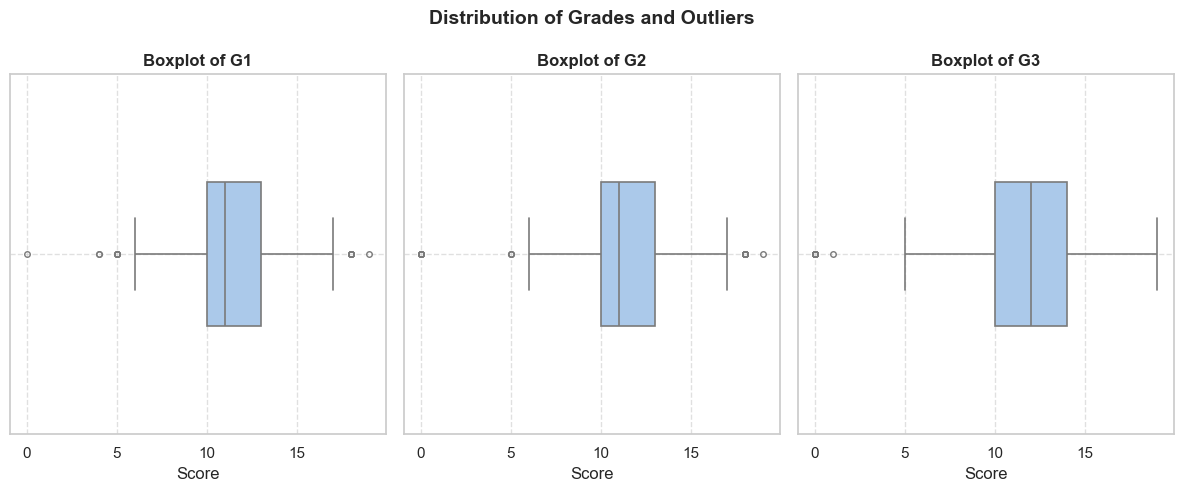

,age,Medu,Fedu,traveltime,studytime,failures,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
count,649.000000,649.000000,649.000000,649.000000,649.000000,649.000000,649.000000,649.000000,649.000000,649.000000,649.000000,649.000000,649.000000,649.000000,649.000000,649.000000
mean,16.744222,2.514638,2.306626,1.568567,1.930663,0.221880,3.930663,3.180277,3.184900,1.502311,2.280431,3.536210,3.659476,11.399076,11.570108,11.906009
std,1.218138,1.134552,1.099931,0.748660,0.829510,0.593235,0.955717,1.051093,1.175766,0.924834,1.284380,1.446259,4.640759,2.745265,2.913639,3.230656
min,15.000000,0.000000,0.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,16.000000,2.000000,1.000000,1.000000,1.000000,0.000000,4.000000,3.000000,2.000000,1.000000,1.000000,2.000000,0.000000,10.000000,10.000000,10.000000
50%,17.000000,2.000000,2.000000,1.000000,2.000000,0.000000,4.000000,3.000000,3.000000,1.000000,2.000000,4.000000,2.000000,11.000000,11.000000,12.000000
75%,18.000000,4.000000,3.000000,2.000000,2.000000,0.000000,5.000000,4.000000,4.000000,2.000000,3.000000,5.000000,6.000000,13.000000,13.000000,14.000000
max,22.000000,4.000000,4.000000,4.000000,4.000000,3.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,32.000000,19.000000,19.000000,19.000000


In [6]:
# Visualizing outliers using a box plot
grades = ["G1", "G2", "G3"]
sns.set_theme(style="whitegrid", palette="pastel")

fig, axes = plt.subplots(1, 3, figsize=(12, 5))
for i, grade in enumerate(grades):
    sns.boxplot(x=df[grade], ax = axes[i], width=0.4, fliersize=4, linewidth=1.2)
    axes[i].set_title(f"Boxplot of {grade}", fontsize=12, fontweight="bold")
    axes[i].set_xlabel("Score")
    axes[i].grid(True, linestyle="--", alpha=0.6)
fig.suptitle("Distribution of Grades and Outliers", fontsize=14, fontweight="bold")
plt.tight_layout()
plt.show()

df.describe()

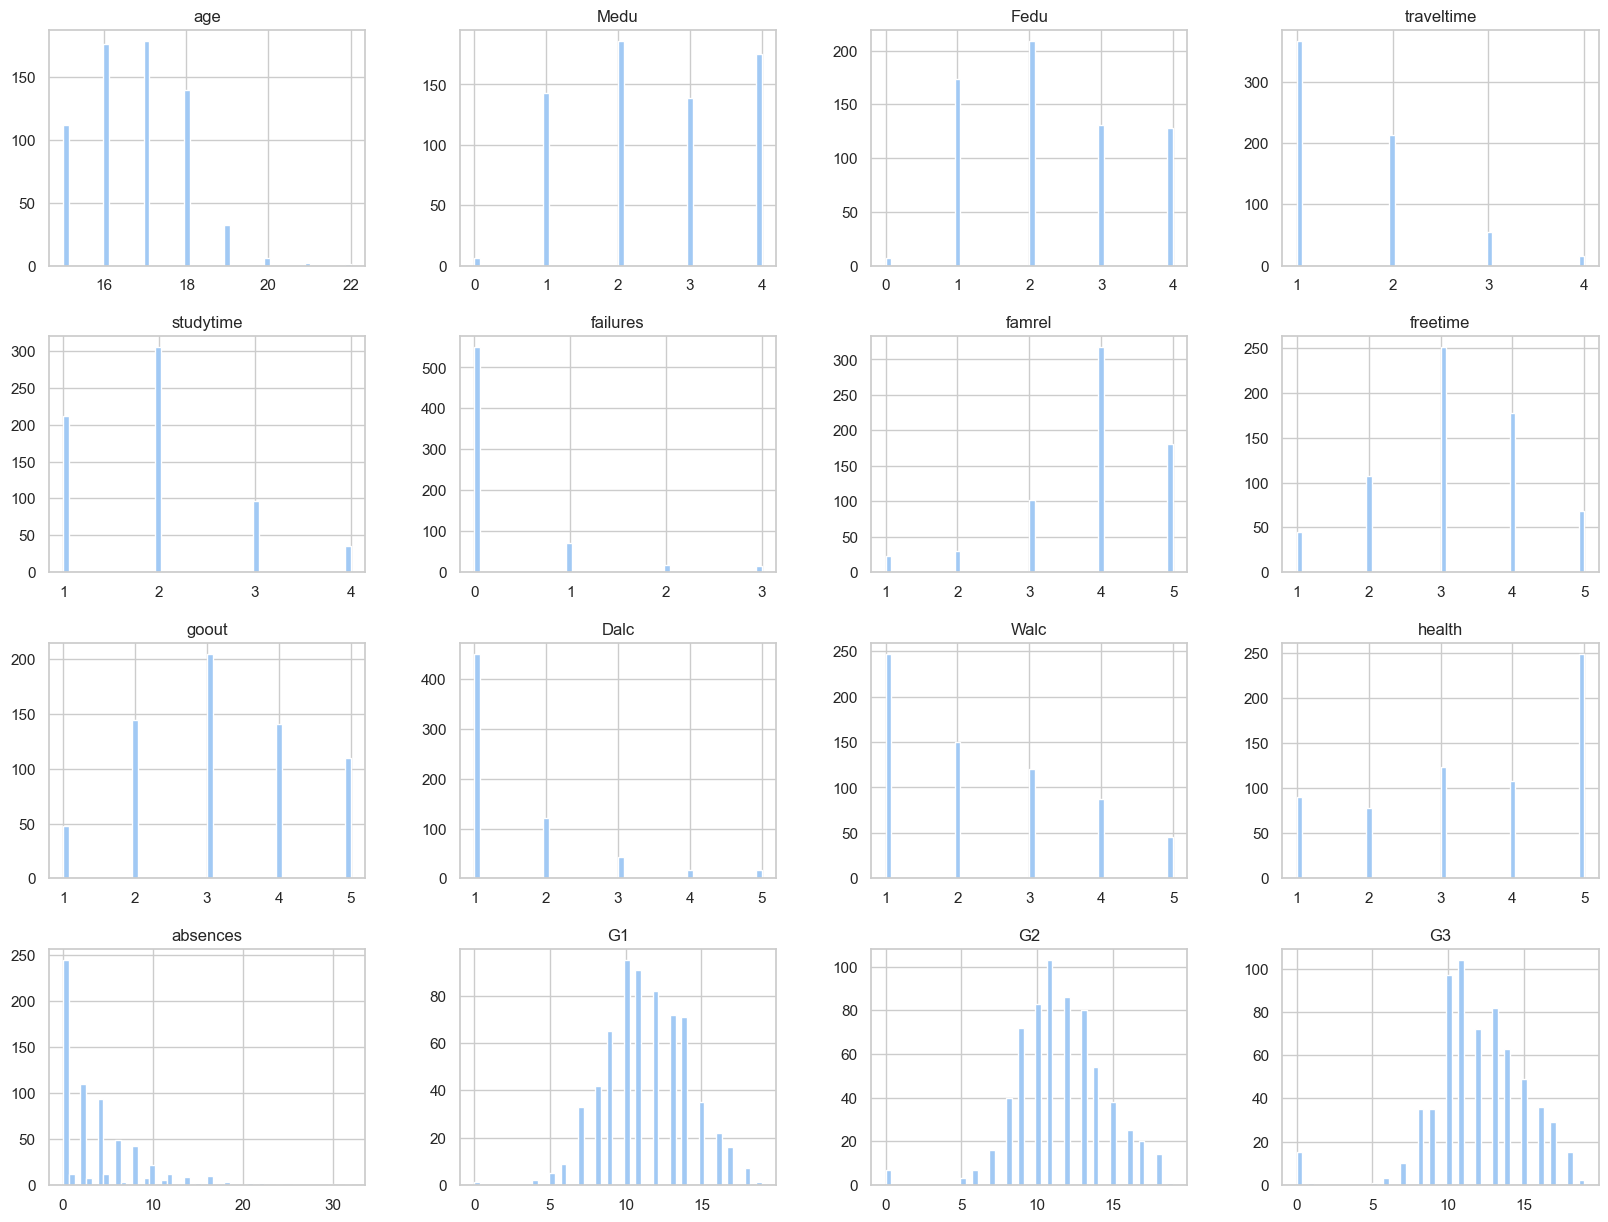

In [7]:
# Distribution of data
df.hist(bins=50, figsize=(20,15))
plt.show()

In [8]:
# Handling duplicates
duplicate_rows = df.duplicated()
print(f"Number of duplicate rows: {duplicate_rows.sum()}")



Number of duplicate rows: 0


In [9]:
# Handling column types
cat_cols = [c for c in df.columns if df[c].dtype == 'object']
# num_cols = [c for c in df.columns if df[c].dtype != 'object' and c != 'target']

num_cols = [c for c in df.columns if df[c].dtype != 'object' and c not in ['target', 'G3']]


print("Categorical columns:", cat_cols)
print("Numerical columns:", num_cols)


Categorical columns: ['school', 'sex', 'address', 'famsize', 'Pstatus', 'Mjob', 'Fjob', 'reason', 'guardian', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery', 'higher', 'internet', 'romantic']
Numerical columns: ['age', 'Medu', 'Fedu', 'traveltime', 'studytime', 'failures', 'famrel', 'freetime', 'goout', 'Dalc', 'Walc', 'health', 'absences', 'G1', 'G2']


In [10]:
# Encode categorical columns
encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
cat_cols_encoded = pd.DataFrame(
    encoder.fit_transform(df[cat_cols]),
    columns=encoder.get_feature_names_out(cat_cols)
)


In [11]:
# Scaling
scaler = StandardScaler()
num_cols_scaled = pd.DataFrame(
    scaler.fit_transform(df[num_cols]),
    columns=num_cols
)

In [12]:
X_prepared = pd.concat([num_cols_scaled, cat_cols_encoded], axis=1)
print("Feature shape:", X_prepared.shape)
X_prepared.head()

Feature shape: (649, 58)


,age,Medu,Fedu,traveltime,studytime,failures,famrel,freetime,goout,Dalc,...,activities_no,activities_yes,nursery_no,nursery_yes,higher_no,higher_yes,internet_no,internet_yes,romantic_no,romantic_yes
0,1.031695,1.310216,1.540715,0.576718,0.083653,-0.374305,0.072606,-0.171647,0.693785,-0.543555,...,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0
1,0.210137,-1.336039,-1.188832,-0.760032,0.083653,-0.374305,1.119748,-0.171647,-0.157380,-0.543555,...,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0
2,-1.432980,-1.336039,-1.188832,-0.760032,0.083653,-0.374305,0.072606,-0.171647,-1.008546,0.538553,...,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0
3,-1.432980,1.310216,-0.278983,-0.760032,1.290114,-0.374305,-0.974536,-1.123771,-1.008546,-0.543555,...,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0
4,-0.611422,0.428131,0.630866,-0.760032,0.083653,-0.374305,0.072606,-0.171647,-1.008546,-0.543555,...,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0


In [13]:
# Outliers -> keep them
for col in num_cols:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)]
    print(f"{col}: {len(outliers)} outliers")


age: 1 outliers
Medu: 0 outliers
Fedu: 0 outliers
traveltime: 16 outliers
studytime: 35 outliers
failures: 100 outliers
famrel: 51 outliers
freetime: 45 outliers
goout: 0 outliers
Dalc: 34 outliers
Walc: 0 outliers
health: 0 outliers
absences: 21 outliers
G1: 16 outliers
G2: 25 outliers


In [14]:
# Combine everything into new dataframe
preprocessed_df = pd.concat([X_prepared, df['G3'].reset_index(drop=True)], axis=1)
print("With G3 shape:", preprocessed_df.shape)
preprocessed_df.head()


With G3 shape: (649, 59)


,age,Medu,Fedu,traveltime,studytime,failures,famrel,freetime,goout,Dalc,...,activities_yes,nursery_no,nursery_yes,higher_no,higher_yes,internet_no,internet_yes,romantic_no,romantic_yes,G3
0,1.031695,1.310216,1.540715,0.576718,0.083653,-0.374305,0.072606,-0.171647,0.693785,-0.543555,...,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,11
1,0.210137,-1.336039,-1.188832,-0.760032,0.083653,-0.374305,1.119748,-0.171647,-0.157380,-0.543555,...,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,11
2,-1.432980,-1.336039,-1.188832,-0.760032,0.083653,-0.374305,0.072606,-0.171647,-1.008546,0.538553,...,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,12
3,-1.432980,1.310216,-0.278983,-0.760032,1.290114,-0.374305,-0.974536,-1.123771,-1.008546,-0.543555,...,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,14
4,-0.611422,0.428131,0.630866,-0.760032,0.083653,-0.374305,0.072606,-0.171647,-1.008546,-0.543555,...,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,13


In [15]:
# High and Low Performance Separating
preprocessed_df['target'] = (preprocessed_df['G3'] >= 12).astype(int)
preprocessed_df.drop(columns=['G3'], inplace=True)
print(preprocessed_df['target'].value_counts())
preprocessed_df.head()

target
1    348
0    301
Name: count, dtype: int64


,age,Medu,Fedu,traveltime,studytime,failures,famrel,freetime,goout,Dalc,...,activities_yes,nursery_no,nursery_yes,higher_no,higher_yes,internet_no,internet_yes,romantic_no,romantic_yes,target
0,1.031695,1.310216,1.540715,0.576718,0.083653,-0.374305,0.072606,-0.171647,0.693785,-0.543555,...,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0
1,0.210137,-1.336039,-1.188832,-0.760032,0.083653,-0.374305,1.119748,-0.171647,-0.157380,-0.543555,...,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0
2,-1.432980,-1.336039,-1.188832,-0.760032,0.083653,-0.374305,0.072606,-0.171647,-1.008546,0.538553,...,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1
3,-1.432980,1.310216,-0.278983,-0.760032,1.290114,-0.374305,-0.974536,-1.123771,-1.008546,-0.543555,...,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1
4,-0.611422,0.428131,0.630866,-0.760032,0.083653,-0.374305,0.072606,-0.171647,-1.008546,-0.543555,...,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,1


## 02 Model Training And Evaluation
### Baseline Models


In [16]:
# Split to training and test
X = preprocessed_df.drop(columns=['target'])
y = preprocessed_df['target']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, stratify=y, random_state=42
)

print("Train set:", X_train.shape)
print("Test set:", X_test.shape)

Train set: (486, 58)
Test set: (163, 58)


In [17]:
# Model Training

# Logistic Regression
log_reg = LogisticRegression(max_iter=500)
log_reg.fit(X_train, y_train)
y_pred_lr = log_reg.predict(X_test)

# Decision Tree
dt = DecisionTreeClassifier(random_state=42)
dt.fit(X_train, y_train)
y_pred_dt = dt.predict(X_test)



Logistic Regression
-------------------
Accuracy : 0.902
Precision: 0.899
Recall   : 0.920
F1-score : 0.909


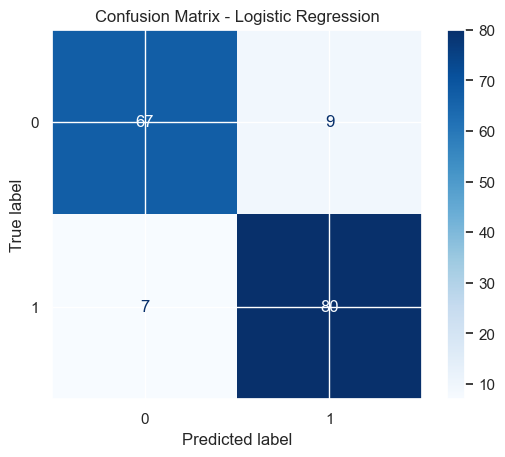


Decision Tree
-------------
Accuracy : 0.933
Precision: 0.963
Recall   : 0.908
F1-score : 0.935


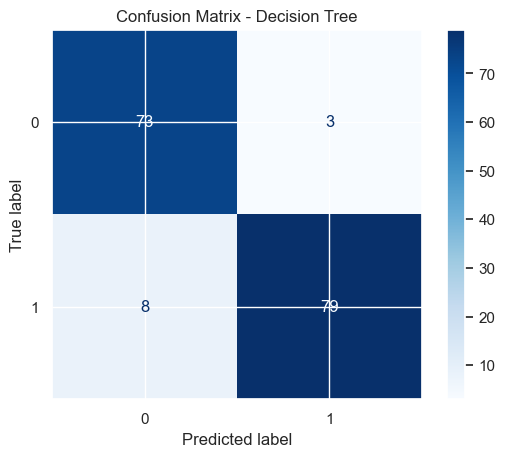

In [18]:
#Evaluate
# Function to evaluate models
def evaluate_model(name, y_true, y_pred):
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred)
    rec = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    print(f"\n{name}")
    print("-" * len(name))
    print(f"Accuracy : {acc:.3f}")
    print(f"Precision: {prec:.3f}")
    print(f"Recall   : {rec:.3f}")
    print(f"F1-score : {f1:.3f}")
    ConfusionMatrixDisplay.from_predictions(y_true, y_pred, cmap="Blues")
    plt.title(f"Confusion Matrix - {name}")
    plt.show()

evaluate_model("Logistic Regression", y_test, y_pred_lr)
evaluate_model("Decision Tree", y_test, y_pred_dt)

## Ensemble Methods


Bagging (Decision Tree)
-----------------------
Accuracy : 0.926
Precision: 0.975
Recall   : 0.885
F1-score : 0.928


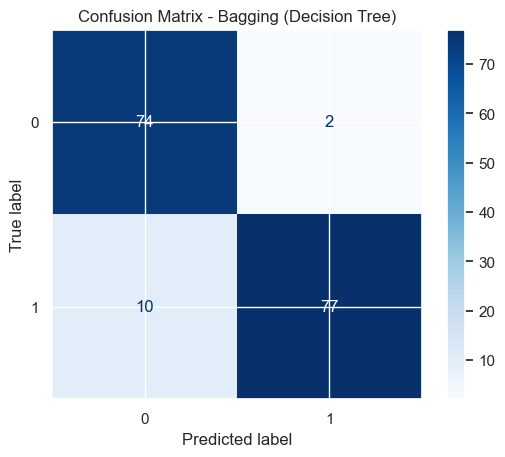

In [19]:
# Bagging
bagging = BaggingClassifier( n_estimators=100, random_state=42)
bagging.fit(X_train, y_train)
y_pred_bag = bagging.predict(X_test)
evaluate_model("Bagging (Decision Tree)", y_test, y_pred_bag)


Random Forest
-------------
Accuracy : 0.926
Precision: 0.975
Recall   : 0.885
F1-score : 0.928


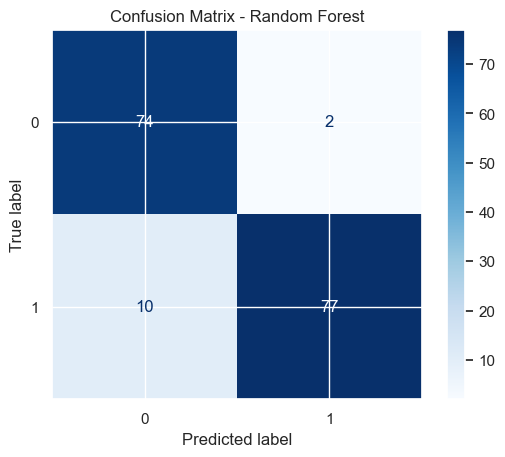

In [20]:
# Random Forest
rf = RandomForestClassifier(n_estimators=200, random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
evaluate_model("Random Forest", y_test, y_pred_rf)


AdaBoost
--------
Accuracy : 0.908
Precision: 0.939
Recall   : 0.885
F1-score : 0.911


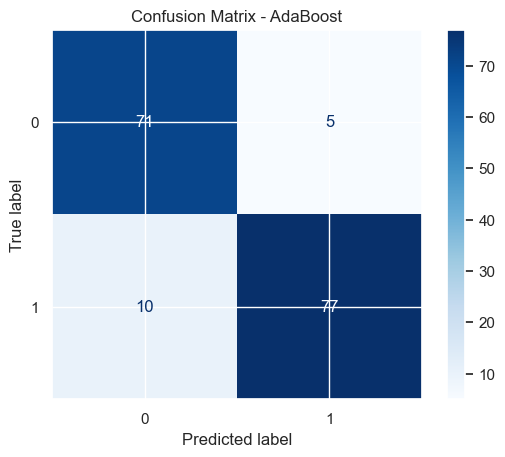

In [21]:
# AdaBoost
ada = AdaBoostClassifier(n_estimators=200, random_state=42)
ada.fit(X_train, y_train)
y_pred_ada = ada.predict(X_test)
evaluate_model("AdaBoost", y_test, y_pred_ada)


Gradient Boosting
-----------------
Accuracy : 0.939
Precision: 0.975
Recall   : 0.908
F1-score : 0.940


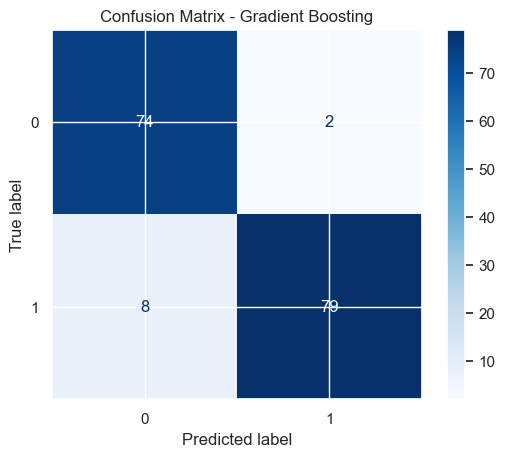

In [22]:
# Gradient Boosting
gb = GradientBoostingClassifier(random_state=42)
gb.fit(X_train, y_train)
y_pred_gb = gb.predict(X_test)
evaluate_model("Gradient Boosting", y_test, y_pred_gb)


Stacking Classifier
-------------------
Accuracy : 0.926
Precision: 0.941
Recall   : 0.920
F1-score : 0.930


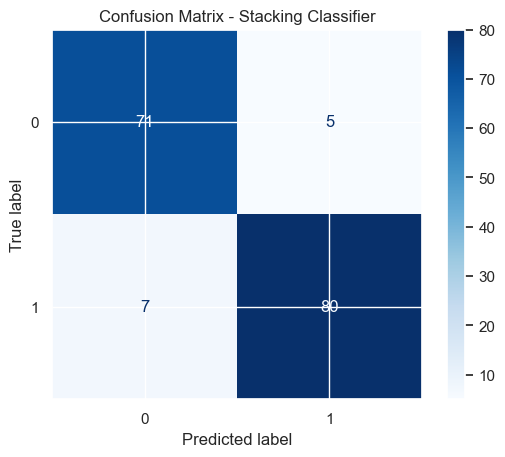

In [23]:
estimators = [
    ('lr', LogisticRegression(max_iter=500)),
    ('dt', DecisionTreeClassifier()),
    ('rf', RandomForestClassifier(n_estimators=100, random_state=42))
]

stack = StackingClassifier(estimators=estimators, final_estimator=LogisticRegression(max_iter=500))
stack.fit(X_train, y_train)
y_pred_stack = stack.predict(X_test)

evaluate_model("Stacking Classifier", y_test, y_pred_stack)

In [24]:
stack = StackingClassifier(
    estimators=estimators,
    final_estimator=LogisticRegression(max_iter=500)
)
stack.fit(X_train, y_train)

print("Which base model contributed most?")
for name, model in estimators:
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print(f"{name} Accuracy: {accuracy_score(y_test, y_pred):.3f}")

Which base model contributed most?
lr Accuracy: 0.902
dt Accuracy: 0.920
rf Accuracy: 0.926


In [25]:
models = {
    'Logistic Regression': y_pred_lr,
    'Decision Tree': y_pred_dt,
    'Bagging': y_pred_bag,
    'Random Forest': y_pred_rf,
    'AdaBoost': y_pred_ada,
    'Gradient Boosting': y_pred_gb,
    'Stacking': y_pred_stack
}

results = []
for name, pred in models.items():
    results.append({
        'Model': name,
        'Accuracy': accuracy_score(y_test, pred),
        'Precision': precision_score(y_test, pred),
        'Recall': recall_score(y_test, pred),
        'F1 Score': f1_score(y_test, pred)
    })

results_df = pd.DataFrame(results).sort_values(by='F1 Score', ascending=False)
print(results_df)

                 Model  Accuracy  Precision    Recall  F1 Score
5    Gradient Boosting  0.938650   0.975309  0.908046  0.940476
1        Decision Tree  0.932515   0.963415  0.908046  0.934911
6             Stacking  0.926380   0.941176  0.919540  0.930233
2              Bagging  0.926380   0.974684  0.885057  0.927711
3        Random Forest  0.926380   0.974684  0.885057  0.927711
4             AdaBoost  0.907975   0.939024  0.885057  0.911243
0  Logistic Regression  0.901840   0.898876  0.919540  0.909091


Accuracy: Computes the proportion of correct predictions

Precision: Correctness of positive predictions.

Recall: Measures how many actual positives are correctly predicted.

F1: Combines precision and recall into one metric (Useful when we need a balance between false positives and false negatives.)

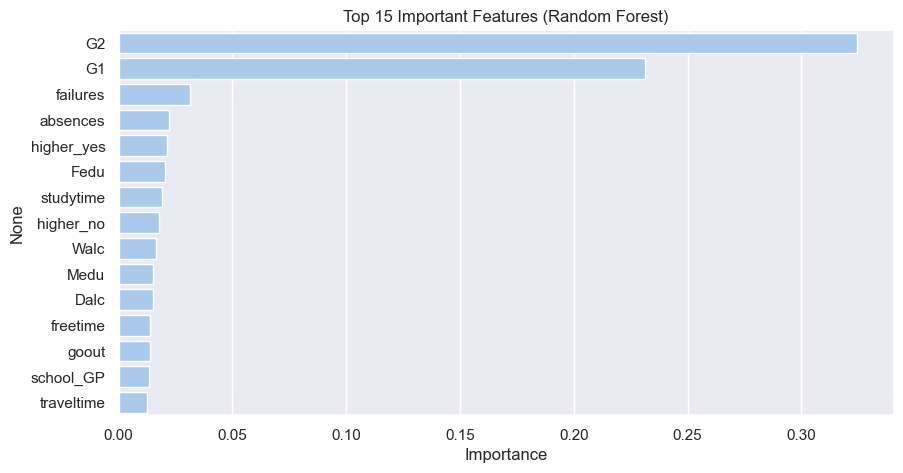

In [26]:
importances = rf.feature_importances_
feat_imp = pd.Series(importances, index=X.columns).sort_values(ascending=False)

plt.figure(figsize=(10,5))
sns.barplot(x=feat_imp[:15], y=feat_imp.index[:15])
plt.title("Top 15 Important Features (Random Forest)")
plt.xlabel("Importance")
plt.show()


### 1. Which ensemble method achieved the best accuracy? Why might that be so?

Gradient Boosting.

It builds models sequentially, where each new tree corrects the previous model’s residual errors --> reduces both
bias and variance.
Corrects errors iteratively and adapts to difficult cases.

---
### 2. How does variance reduction differ between bagging and boosting?

Bagging lowers variance with training different tree independently, while Boosting lowers both bias and variance by sequentially refining weak models.

---
### 3. In the stacking approach, which base model contributed most to performance?

Random Forest Classifier.

---
### 4. Discuss feature importance and its implications for student success.

The grades in earlier years highly reflects the latest year's results.
Study time, failures, absences, and parental education: represents academic consistency and learning environment.
School support and extra activities: may influence engagement and time management.

---
### 5. How could this framework be adapted to predict student dropout risk?

Define new target --> dropout (absences, low grades)
Add behavioral features: attendance, login frequency (if online), number of failed subjects, social indicators
Feature engineering: aggregate semester data (grades)
Use same process and evaluation.

